In [134]:
import arviz as az
import os.path as op
from tqdm.contrib.itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Distance to RNP
from risk_experiment.cogmodels.fit_probit import build_model, get_data
from risk_experiment.cogmodels.utils import get_fake_data, extract_intercept_gamma
cm = 1/2.54  # centimeters in inches

palette = sns.color_palette()[6:]
order = ['Low activation', 'High activation']

In [135]:
def load(model_label, session, bids_folder='/data/ds-risk', roi=None):
    df = get_data(model_label, session, bids_folder, roi=roi)
    model = build_model(model_label, df, session, bids_folder, roi=roi)
    idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_ses-{session}_roi-{roi}_trace.netcdf')

    return df, model, idata

def get_hdi(x):
    return tuple(az.hdi(x.values))

# Simple model (order x pupil split)

In [136]:
rois = ['dmidbrain', 'vtav2', 'sncv2', 'meynert', 'lc']

In [137]:
rnps = []
gammas = []

for roi in rois:
    df, model, idata = load('probit_subcortical_response2', '7t2', roi=roi)
    intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
    rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
    rnp = rnp[(rnp['rnp'] > 0.0) & (rnp['rnp'] < 1.0)]
    rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

    gamma = gamma.stack([-2, -1])

    rnps.append(rnp)
    gammas.append(gamma)

100%|██████████| 30/30 [00:01<00:00, 25.35it/s]


In [138]:
rnp = pd.concat(rnps, keys=rois, names=['roi'])
gamma = pd.concat(gammas, keys=rois, names=['roi'])

dmidbrain


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.3735
0.37475
0.48424999999999996
lc


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.1885
0.21625
0.13
meynert


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.34525
0.33625000000000005
0.2715
sncv2


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.26849999999999996
0.038
0.04425000000000001
vtav2


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.42175
0.42100000000000004
0.39


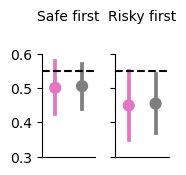

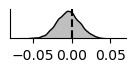

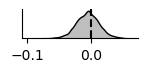

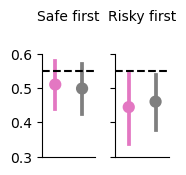

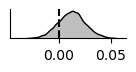

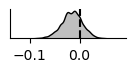

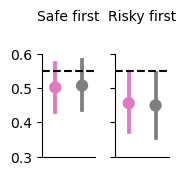

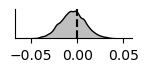

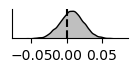

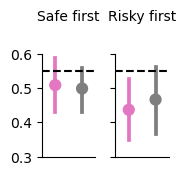

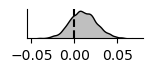

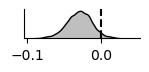

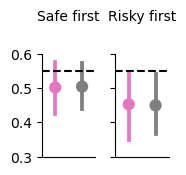

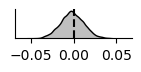

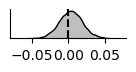

In [139]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Subcortical response'] = rnp.index.get_level_values('median_split_subcortical_response')#.map({True:'Large', False:'Small'})


for roi, r in rnp.groupby('roi'):

  print(roi)
  fac = sns.catplot(data=r.reset_index(), x='Subcortical response', y='rnp', col='Order', kind='point', palette=palette,
                    #  order=['Low pupil dilation', 'High pupil dilation'],
                    errorbar=get_hdi,
                    col_order=['Safe first', 'Risky first'],
                    aspect=.5, height=1.5*3.2*cm, legend=False)

  fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.3, 0.6))
  fac.set_titles('{col_name}', y=1.25)
  # fac.set(siptit'{col_name}')
  # fac.fig.suptitle(roi)
  # fac.add_legend()

  fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))

  diff1 = (r.xs(False, 0, 'risky_first').xs('Low activation', 0, 'median_split_subcortical_response')['rnp'] - r.xs(False, 0, 'risky_first').xs('High activation', 0, 'median_split_subcortical_response')['rnp']) 

  p = (diff1 > 0.0).mean()
  print(np.min((p, 1-p)))

  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_roi-{roi}_rnp.pdf', bbox_inches='tight')

  plt.figure()
  sns.kdeplot(diff1, fill=True, color='k')
  sns.despine()

  plt.axvline(0.0, c='k', ls='--')
  sns.despine()
  plt.gcf().set_size_inches(1.5, .375)
  plt.xlabel(None)
  plt.ylabel(None)
  plt.yticks([])

  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_roi-{roi}_rnp_safe_first_diff.pdf', bbox_inches='tight')

  plt.figure()
  diff2 = (r.xs(True, 0, 'risky_first').xs('Low activation', 0, 'median_split_subcortical_response')['rnp'] - r.xs(True, 0, 'risky_first').xs('High activation', 0, 'median_split_subcortical_response')['rnp']) 

  p = (diff2 > 0.0).mean()
  print(np.min((p, 1-p)))

  sns.kdeplot(diff2, fill=True, color='k')
  sns.despine()

  plt.axvline(0.0, c='k', ls='--')
  sns.despine()
  plt.gcf().set_size_inches(1.5, .375)
  plt.xlabel(None)
  plt.ylabel(None)
  plt.yticks([])

  p = ((diff1 - diff2) > 0.0).mean()
  print(np.min((p, 1-p)))
  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_roi-{roi}_rnp_risky_first_diff.pdf', bbox_inches='tight')


    # plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_n1_pre_rnp.pdf'), bbox_inches='tight')

dmidbrain


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.00725
0.101
0.22125
lc


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.27249999999999996
0.01075
0.015000000000000013
meynert
0.439


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.12375000000000003
0.16775
sncv2


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.00825
0.28774999999999995
0.01575
vtav2


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.1275
0.2235
0.399


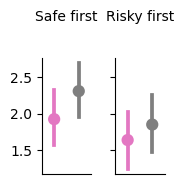

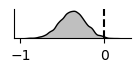

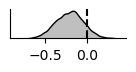

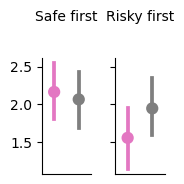

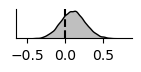

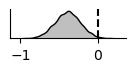

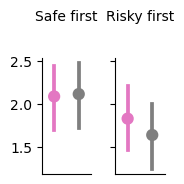

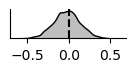

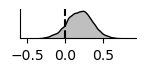

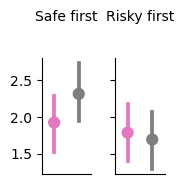

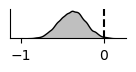

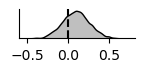

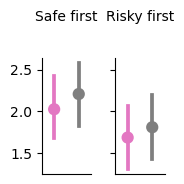

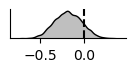

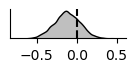

In [140]:
gamma['Order'] = gamma.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
gamma['Subcortical response'] = gamma.index.get_level_values('median_split_subcortical_response')#.map({True:'Large', False:'Small'})


for roi, g in gamma.groupby('roi'):
  print(roi)
  fac = sns.catplot(data=g.reset_index(), x='Subcortical response', y='gamma', col='Order', kind='point', palette=palette,
                     order=['Low activation', 'High activation'],
                    errorbar=get_hdi,
                    col_order=['Safe first', 'Risky first'],
                    aspect=.5, height=1.5*3.2*cm, legend=False)

  fac.set(ylabel=None, xlabel=None, xticks=[])
  fac.set_titles('{col_name}', y=1.25)

  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_roi-{roi}_gamma.pdf', bbox_inches='tight')

  diff1 = (g.xs(False, 0, 'risky_first').xs('Low activation', 0, 'median_split_subcortical_response')['gamma'] - g.xs(False, 0, 'risky_first').xs('High activation', 0, 'median_split_subcortical_response')['gamma']) 

  p = (diff1 > 0.0).mean()
  print(np.min((p, 1-p)))

  plt.figure()
  sns.kdeplot(diff1, fill=True, color='k')
  sns.despine()

  plt.axvline(0.0, c='k', ls='--')
  sns.despine()
  plt.gcf().set_size_inches(1.5, .375)
  plt.xlabel(None)
  plt.ylabel(None)
  plt.yticks([])

  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_roi-{roi}_gamma_safe_first_diff.pdf', bbox_inches='tight')
  # plt.savefig('/data/ds-risk/derivatives/figures/pupil_n1_pre_rnp_safe_first_diff.pdf', bbox_inches='tight')

  plt.figure()
  diff2 = (g.xs(True, 0, 'risky_first').xs('Low activation', 0, 'median_split_subcortical_response')['gamma'] - g.xs(True, 0, 'risky_first').xs('High activation', 0, 'median_split_subcortical_response')['gamma']) 

  p = (diff2 > 0.0).mean()
  print(np.min((p, 1-p)))

  sns.kdeplot(diff2, fill=True, color='k')
  sns.despine()

  plt.axvline(0.0, c='k', ls='--')
  sns.despine()
  plt.gcf().set_size_inches(1.5, .375)
  plt.xlabel(None)
  plt.ylabel(None)
  plt.yticks([])

  p = ((diff1 - diff2) > 0.0).mean()
  print(np.min((p, 1-p)))
  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_roi-{roi}_gamma_risky_first_diff.pdf', bbox_inches='tight')

# Complex model (n_safe x order x pupilsplit)

In [141]:
rnps = []
gammas = []

for roi in rois:
    df, model, idata = load('probit_subcortical_response3', '7t2', roi=roi)
    intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
    rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
    rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

    gamma = gamma.stack([-2, -1])

    rnps.append(rnp)
    gammas.append(gamma)

100%|██████████| 30/30 [00:01<00:00, 24.09it/s]


FileNotFoundError: [Errno 2] No such file or directory: b'/data/ds-risk/derivatives/cogmodels/model-probit_subcortical_response3_ses-7t2_roi-dmidbrain_trace.netcdf'

In [142]:
rnp = pd.concat(rnps, keys=rois, names=['roi'])
gamma = pd.concat(gammas, keys=rois, names=['roi'])

ValueError: No objects to concatenate

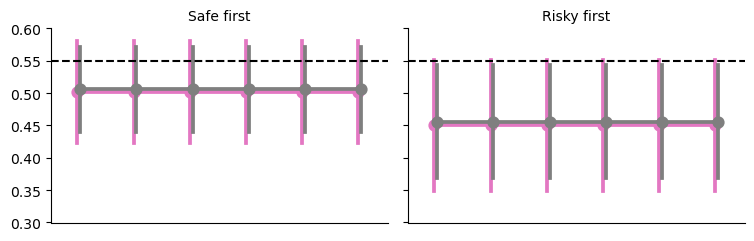

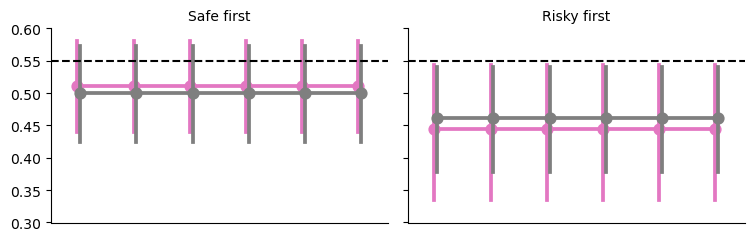

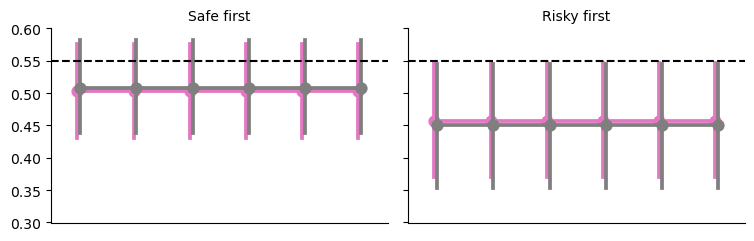

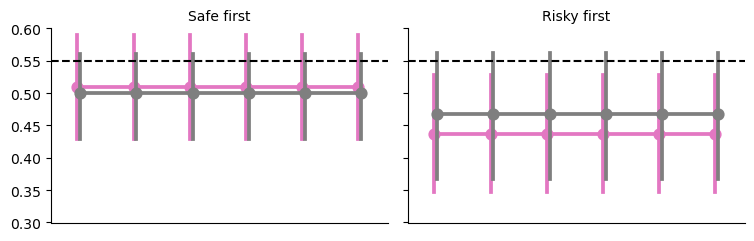

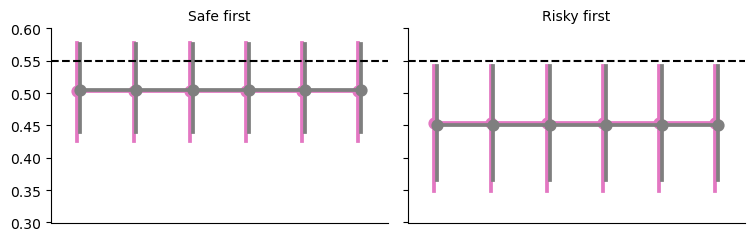

In [143]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Subcortical response'] = rnp.index.get_level_values('median_split_subcortical_response')#.map({True:'Large', False:'Small'})

for roi, r in rnp.groupby('roi'):
  fac = sns.catplot(data=r.reset_index(), x='n_safe', hue='Subcortical response', y='rnp', col='Order', kind='point', palette=palette,
                    hue_order=['Low activation', 'High activation'],
                    dodge=True,
                    errorbar=get_hdi,
                  #   col_order=['Safe first', 'Risky first'],
                    aspect=1.5, height=2*3.2*cm, legend=False)

  fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.3, 0.6))
  fac.set_titles('{col_name}')

  fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))


  # plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_complex_n1_prepost_rnp.pdf'), bbox_inches='tight')

# Subjectwise

In [144]:
rnps = []
gammas = []

for roi in rois:
    df, model, idata = load('probit_subcortical_response3', '7t2', roi=roi)
    intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
    rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
    rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)
    rnp = rnp[(rnp['rnp'] > 0.0) & (rnp['rnp'] < 1.0)]

    gamma = gamma.stack([-2, -1])

    rnps.append(rnp)
    gammas.append(gamma)


rnp = pd.concat(rnps, keys=rois, names=['roi'])
gamma = pd.concat(gammas, keys=rois, names=['roi'])

rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Subcortical response'] = rnp.index.get_level_values('median_split_subcortical_response')#.map({True:'Large', False:'Small'})
rnp['distance_to_risk_neutral'] = (rnp['rnp'] - .55).abs()

# tmp = rnp.groupby(['chain', 'draw', 'Pupil size']).mean()

# fac = sns.FacetGrid(tmp.reset_index(), hue='Pupil size', palette=palette,
#                 #    hue_order=['Low neural uncertainty', 'High neural uncertainty'],
#                     height=6.4*cm)
# fac.map(sns.kdeplot, 'distance_to_risk_neutral', fill=True)

# fac.set(xlabel=None, ylabel=None, yticks=[])
# split = tmp['distance_to_risk_neutral'].unstack('Pupil size')
# print((split[order[0]] > split[order[1]]).mean())
# # plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'model-rnp_neural9_rnp_distance.pdf'), bbox_inches='tight')

100%|██████████| 30/30 [00:01<00:00, 24.39it/s]


FileNotFoundError: [Errno 2] No such file or directory: b'/data/ds-risk/derivatives/cogmodels/model-probit_subcortical_response3_ses-7t2_roi-dmidbrain_trace.netcdf'

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_94142/1763629156.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = r.groupby(['chain', 'draw', 'Subcortical response']).mean()


0.86175


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_94142/1763629156.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = r.groupby(['chain', 'draw', 'Subcortical response']).mean()


0.463


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_94142/1763629156.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = r.groupby(['chain', 'draw', 'Subcortical response']).mean()


0.69775
0.8235


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_94142/1763629156.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = r.groupby(['chain', 'draw', 'Subcortical response']).mean()


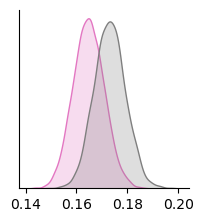

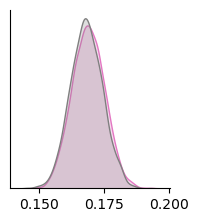

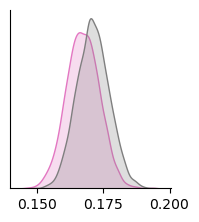

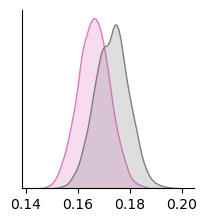

In [ ]:
for roi, r in rnp.groupby('roi'):

    tmp = r.groupby(['chain', 'draw', 'Subcortical response']).mean()

    fac = sns.FacetGrid(tmp.reset_index(), hue='Subcortical response', palette=palette,
                    #    hue_order=['Low neural uncertainty', 'High neural uncertainty'],
                        height=6.4*cm)
    fac.map(sns.kdeplot, 'distance_to_risk_neutral', fill=True)

    fac.set(xlabel=None, ylabel=None, yticks=[])
    split = tmp['distance_to_risk_neutral'].unstack('Subcortical response')
    print((split[order[0]] > split[order[1]]).mean())
    # plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'model-rnp_neural9_rnp_distance.pdf'), bbox_inches='tight')

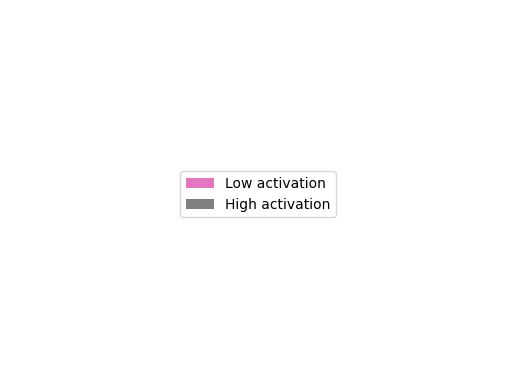

In [133]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


fig = plt.gcf()

legend_elements = [Patch(facecolor=palette[0], label='Low activation'),
                   Patch(facecolor=palette[1], label='High activation') ]


legend = plt.legend(handles=legend_elements, loc='center')
plt.axis('off')

bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig(filename, dpi="figure", bbox_inches=bbox)

plt.savefig('/data/ds-risk/derivatives/figures/subcortical_legend.pdf', bbox_inches=bbox)